In [1]:
!pip uninstall pyTigerGraph -y
!pip install git+https://github.com/tigergraph/pyTigerGraph.git --no-cache

  Cloning https://github.com/tigergraph/pyTigerGraph.git to /tmp/pip-req-build-ajzr_fe6
  Running command git clone --filter=blob:none --quiet https://github.com/tigergraph/pyTigerGraph.git /tmp/pip-req-build-ajzr_fe6
  Resolved https://github.com/tigergraph/pyTigerGraph.git to commit 886de415393d16d7ffab8f90824d2a7e34b8b16a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyTigerGraph: filename=pyTigerGraph-1.2.6-py3-none-any.whl size=135918 sha256=db81300282c8d54d176edd70ac08244cd05d243356d526f3d1cc2d88402f19e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-cm1os_8o/wheels/cc/41/7a/6b8eee74c439c99b3cdb01357d4b426b9a18e51e9571b28b18
Successfully built pyTigerGraph


In [2]:
from pyTigerGraph import TigerGraphConnection
import json

# Read in DB configs
with open('../config.json', "r") as config_file:
    config = json.load(config_file)
    
conn = TigerGraphConnection(
    host=config["host"],
    username=config["username"],
    password=config["password"]
)

In [3]:
from pyTigerGraph.datasets import Datasets

dataset = Datasets("imdb")

conn.ingestDataset(dataset, getToken=config["getToken"])

A folder with name imdb already exists in ./tmp. Skip downloading.
---- Checking database ----
A graph with name imdb already exists in the database. Skip ingestion.
Graph name is set to imdb for this connection.


In [4]:
from pyTigerGraph.visualization import drawSchema

drawSchema(conn.getSchema(force=True))

CytoscapeWidget(cytoscape_layout={'name': 'circle', 'animate': True, 'padding': 1}, cytoscape_style=[{'selecto…

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [6]:
np_loader = conn.gds.nodepieceLoader(batch_size = 64,
                                     compute_anchors = True,
                                     anchor_percentage = 0.1,
                                     v_feats = {"Movie": [], "Actor": [], "Director": []}, 
                                     target_vertex_types=["Movie", "Actor", "Director"], 
                                     max_anchors=5,
                                     max_relational_context=5,
                                     clear_cache=True,
                                     use_cache=True,
                                     e_types=conn.getEdgeTypes(),
                                     timeout=204_800_000)
np_loader.precompute()

Number of Anchors: 1223


In [7]:
def process_anchors(batch):
    for v_type in batch.metadata()[0]:
        batch_ancs = []
        batch_dists = []
        for v in batch[v_type]["anchors"]:
            anchors = [np_loader.idToIdx[x] for x in v.keys()]
            dists = [np_loader.idToIdx["dist_"+v[str(y)]] for y in v.keys()]
            dists = dists + [np_loader.idToIdx["PAD"] for z in range(len(dists), np_loader._payload["max_anchors"])]
            anchors = anchors + [np_loader.idToIdx["PAD"] for z in range(len(anchors), np_loader._payload["max_anchors"])]
            batch_ancs.append(torch.tensor(anchors, dtype=torch.long))
            batch_dists.append(torch.tensor(dists, dtype=torch.long))
        batch[v_type]["anchors"] = torch.stack(batch_ancs)
        batch[v_type]["distance"] = torch.stack(batch_dists)
    return batch

In [8]:
# Hyperparameters
hp = {
    "hidden_dim": 128,
    "num_layers": 2,
    "dropout": 0.5,
    "lr": 0.0005,
    "l2_penalty": 0.01,
    "batch_size": 128, 
    "num_neighbors": 10, 
    "num_hops": 2
}

In [9]:
train_loader = conn.gds.neighborLoader(
    v_in_feats={"Movie": ["x"], "Actor": ["x"], "Director": ["x"]}, 
    v_out_labels={"Movie": ["y"]},
    v_extra_feats={"Movie": ["train_mask", "val_mask", "test_mask", "anchors"], "Actor": ["anchors"], "Director": ["anchors"]},
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    shuffle=True,
    filter_by={"Movie":"train_mask"},
    callback_fn = lambda x: process_anchors(x))

In [10]:
valid_loader = conn.gds.neighborLoader(
    v_in_feats={"Movie": ["x"], "Actor": ["x"], "Director": ["x"]}, 
    v_out_labels={"Movie": ["y"]},
    v_extra_feats={"Movie": ["train_mask", "val_mask", "test_mask", "anchors"], "Actor": ["anchors"], "Director": ["anchors"]},
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    shuffle=True,
    filter_by={"Movie":"val_mask"},
    callback_fn = lambda x: process_anchors(x))

In [11]:
for batch in train_loader:
    print(batch)
    break

HeteroData(
  Movie={
    x=[1085, 3066],
    y=[1085],
    train_mask=[1085],
    val_mask=[1085],
    test_mask=[1085],
    anchors=[1085, 5],
    is_seed=[1085],
    distance=[1085, 5]
  },
  Actor={
    x=[260, 3066],
    anchors=[260, 5],
    is_seed=[260],
    distance=[260, 5]
  },
  Director={
    x=[89, 3066],
    anchors=[89, 5],
    is_seed=[89],
    distance=[89, 5]
  },
  (Movie, movie_actor, Actor)={ edge_index=[2, 279] },
  (Movie, movie_director, Director)={ edge_index=[2, 93] },
  (Actor, actor_movie, Movie)={ edge_index=[2, 1174] },
  (Director, director_movie, Movie)={ edge_index=[2, 321] }
)


In [12]:
class BaseNodePiece(nn.Module):
    def __init__(self, 
                 vocab_size:int,
                 sequence_length:int,
                 embedding_dim:int=128):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.sequence_length = sequence_length
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        torch.nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, anchors, distances):
        anc_emb = self.embedding(anchors)
        anc_emb += self.embedding(distances)
        return anc_emb

In [13]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, to_hetero

In [14]:
emb_model = BaseNodePiece(np_loader.num_tokens, np_loader._payload["max_rel_context"] + np_loader._payload["max_anchors"])

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a normal (homogeneous) GAT model
class GraphSAGE(torch.nn.Module):
    def __init__(
        self, num_features, num_layers, out_dim, dropout, hidden_dim
    ):
        super().__init__()
        self.dropout = dropout
        self.embedding = emb_model
        self.layers = torch.nn.ModuleList()
        for i in range(num_layers):
            in_units = num_features if i == 0 else hidden_dim
            out_units = out_dim if i == (num_layers - 1) else hidden_dim
            self.layers.append(
                SAGEConv(in_units, out_units)
            )

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()
            
    def get_embedding(self, x, edge_index, anchors, distances):
        emb = self.embedding(anchors, distances)
        x = x.float()
        x = torch.concat([x, torch.flatten(emb, start_dim=1)], dim=1)
        #x = torch.flatten(emb, start_dim=1)
        for layer in self.layers[:-1]:
            x = layer(x, edge_index)
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        return x

    def forward(self, x, edge_index, anchors, distances):
        emb = self.embedding(anchors, distances)
        x = x.float()
        x = torch.concat([x, torch.flatten(emb, start_dim=1)], dim=1)
        #x = torch.flatten(emb, start_dim=1)
        for layer in self.layers[:-1]:
            x = layer(x, edge_index)
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.layers[-1](x, edge_index)
        return x
    
model = GraphSAGE(
    num_features=3066+(128*5),
    num_layers=hp["num_layers"],
    out_dim=3,
    dropout=hp["dropout"],
    hidden_dim=hp["hidden_dim"],
)

# Convert it to a heterogeneous model. See https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.to_hetero_transformer.to_hetero for details.
metadata = (['Actor', 'Movie', 'Director'], 
            [('Actor', 'actor_movie', 'Movie'), 
             ('Movie', 'movie_actor', 'Actor'), 
             ('Movie', 'movie_director', 'Director'), 
             ('Director', 'director_movie', 'Movie')])
model = to_hetero(model, metadata, aggr='sum').to(device)

optimizer = torch.optim.Adam(
    model.parameters(), lr=hp["lr"], weight_decay=hp["l2_penalty"]
)

/opt/conda/lib/python3.9/site-packages/torch_geometric/nn/to_hetero_transformer.py:295: UserWarning: 'embedding' will be duplicated, but its parameters cannot be reset. To suppress this warning, add a 'reset_parameters()' method to 'embedding'
  warnings.warn(


In [16]:
model

GraphModule(
  (embedding): ModuleDict(
    (Actor): BaseNodePiece(
      (embedding): Embedding(1237, 128)
    )
    (Movie): BaseNodePiece(
      (embedding): Embedding(1237, 128)
    )
    (Director): BaseNodePiece(
      (embedding): Embedding(1237, 128)
    )
  )
  (layers): ModuleList(
    (0): ModuleDict(
      (Actor__actor_movie__Movie): SAGEConv(3706, 128)
      (Movie__movie_actor__Actor): SAGEConv(3706, 128)
      (Movie__movie_director__Director): SAGEConv(3706, 128)
      (Director__director_movie__Movie): SAGEConv(3706, 128)
    )
    (1): ModuleDict(
      (Actor__actor_movie__Movie): SAGEConv(128, 3)
      (Movie__movie_actor__Actor): SAGEConv(128, 3)
      (Movie__movie_director__Director): SAGEConv(128, 3)
      (Director__director_movie__Movie): SAGEConv(128, 3)
    )
  )
)

In [17]:
from datetime import datetime

from pyTigerGraph.gds.metrics import Accumulator, Accuracy
from torch.utils.tensorboard import SummaryWriter

/opt/conda/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [18]:
log_dir = "logs/imdb/hgat/subgraph/" + datetime.now().strftime("%Y%m%d-%H%M%S")
train_log = SummaryWriter(log_dir+"/train")
valid_log = SummaryWriter(log_dir+"/valid")
global_steps = 0
logs = {}
for epoch in range(10):
    # Train
    model.train()
    epoch_train_loss = Accumulator()
    epoch_train_acc = Accuracy()
    # Iterate through the loader to get a stream of subgraphs instead of the whole graph
    for bid, batch in enumerate(train_loader):
        batchsize = batch["Movie"].x.shape[0]
        batch.to(device)
        # Forward pass
        out = model(batch.x_dict, batch.edge_index_dict, batch.anchors_dict, batch.distance_dict)
        # Calculate loss
        mask = batch["Movie"].is_seed
        loss = F.cross_entropy(out["Movie"][mask], batch["Movie"].y[mask])
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss.update(loss.item() * batchsize, batchsize)
        # Predict on training data
        with torch.no_grad():
            pred = out["Movie"].argmax(dim=1)
            epoch_train_acc.update(pred[mask], batch["Movie"].y[mask])
        # Log training status after each batch
        logs["loss"] = epoch_train_loss.mean
        logs["acc"] = epoch_train_acc.value
        print(
            "Epoch {}, Train Batch {}, Loss {:.4f}, Accuracy {:.4f}".format(
                epoch, bid, logs["loss"], logs["acc"]
            )
        )
        train_log.add_scalar("Loss", logs["loss"], global_steps)
        train_log.add_scalar("Accuracy", logs["acc"], global_steps)
        train_log.flush()
        global_steps += 1
    # Evaluate
    model.eval()
    epoch_val_loss = Accumulator()
    epoch_val_acc = Accuracy()
    for batch in valid_loader:
        batchsize = batch["Movie"].x.shape[0]
        batch.to(device)
        with torch.no_grad():
            # Forward pass
            out = model(batch.x_dict, batch.edge_index_dict, batch.anchors_dict, batch.distance_dict)
            # Calculate loss
            mask = batch["Movie"].is_seed
            valid_loss = F.cross_entropy(out["Movie"][mask], batch["Movie"].y[mask])
            epoch_val_loss.update(valid_loss.item() * batchsize, batchsize)
            # Prediction
            pred = out["Movie"].argmax(dim=1)
            epoch_val_acc.update(pred[mask], batch["Movie"].y[mask])
    # Log testing result after each epoch
    logs["val_loss"] = epoch_val_loss.mean
    logs["val_acc"] = epoch_val_acc.value
    print(
        "Epoch {}, Valid Loss {:.4f}, Valid Accuracy {:.4f}".format(
            epoch, logs["val_loss"], logs["val_acc"]
        )
    )
    valid_log.add_scalar("Loss", logs["val_loss"], global_steps)
    valid_log.add_scalar("Accuracy", logs["val_acc"], global_steps)
    valid_log.flush()

Epoch 0, Train Batch 0, Loss 1.1079, Accuracy 0.3333
Epoch 0, Train Batch 1, Loss 1.1028, Accuracy 0.3420
Epoch 0, Train Batch 2, Loss 1.0927, Accuracy 0.3527
Epoch 0, Train Batch 3, Loss 1.0809, Accuracy 0.3650
Epoch 0, Valid Loss 1.0732, Valid Accuracy 0.3975
Epoch 1, Train Batch 0, Loss 1.0278, Accuracy 0.4298
Epoch 1, Train Batch 1, Loss 0.9860, Accuracy 0.4862
Epoch 1, Train Batch 2, Loss 0.9707, Accuracy 0.4904
Epoch 1, Train Batch 3, Loss 0.9623, Accuracy 0.5075
Epoch 1, Valid Loss 1.0524, Valid Accuracy 0.4225
Epoch 2, Train Batch 0, Loss 0.9170, Accuracy 0.5922
Epoch 2, Train Batch 1, Loss 0.9019, Accuracy 0.5949
Epoch 2, Train Batch 2, Loss 0.8805, Accuracy 0.6589
Epoch 2, Train Batch 3, Loss 0.8704, Accuracy 0.6925
Epoch 2, Valid Loss 1.0490, Valid Accuracy 0.4600
Epoch 3, Train Batch 0, Loss 0.7794, Accuracy 0.8636
Epoch 3, Train Batch 1, Loss 0.8013, Accuracy 0.8009
Epoch 3, Train Batch 2, Loss 0.7928, Accuracy 0.7966
Epoch 3, Train Batch 3, Loss 0.7745, Accuracy 0.8025
Ep

In [19]:
test_loader = conn.gds.neighborLoader(
    v_in_feats={"Movie": ["x"], "Actor": ["x"], "Director": ["x"]}, 
    v_out_labels={"Movie": ["y"]},
    v_extra_feats={"Movie": ["train_mask", "val_mask", "test_mask", "anchors"], "Actor": ["anchors"], "Director": ["anchors"]},
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    shuffle=True,
    filter_by={"Movie":"test_mask"},
    callback_fn = lambda x: process_anchors(x))

In [20]:
model.eval()
acc = Accuracy()
for batch in test_loader:
    batch.to(device)
    with torch.no_grad():
        pred = model(batch.x_dict, batch.edge_index_dict, batch.anchors_dict, batch.distance_dict)["Movie"].argmax(dim=1)
        mask = batch["Movie"].is_seed
        acc.update(pred[mask], batch["Movie"].y[mask])
print("Accuracy: {:.4f}".format(acc.value))

Accuracy: 0.4882


In [21]:
infer_loader = conn.gds.neighborLoader(
    v_in_feats={"Movie": ["x"], "Actor": ["x"], "Director": ["x"]}, 
    v_out_labels={"Movie": ["y"]},
    v_extra_feats={"Movie": ["train_mask", "val_mask", "test_mask", "anchors"], "Actor": ["anchors"], "Director": ["anchors"]},
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    shuffle=False,
    filter_by={"Movie":"test_mask"},
    callback_fn = lambda x: process_anchors(x))

In [22]:
# Fetch specific nodes by their IDs and do prediction. 
# Each node is represented by a dict with two mandatory keys: primary_id and type.
input_nodes = [{"primary_id": 7, "type": "Movie"}, 
               {"primary_id": 55, "type": "Movie"}]
data = infer_loader.fetch(input_nodes)

In [23]:
data

HeteroData(
  Movie={
    x=[54, 3066],
    y=[54],
    train_mask=[54],
    val_mask=[54],
    test_mask=[54],
    anchors=[54, 5],
    is_seed=[54],
    primary_id=[54],
    distance=[54, 5]
  },
  Actor={
    x=[6, 3066],
    anchors=[6, 5],
    is_seed=[6],
    primary_id=[6],
    distance=[6, 5]
  },
  Director={
    x=[2, 3066],
    anchors=[2, 5],
    is_seed=[2],
    primary_id=[2],
    distance=[2, 5]
  },
  (Movie, movie_actor, Actor)={ edge_index=[2, 6] },
  (Movie, movie_director, Director)={ edge_index=[2, 2] },
  (Actor, actor_movie, Movie)={ edge_index=[2, 54] },
  (Director, director_movie, Movie)={ edge_index=[2, 11] }
)

In [24]:
# Predict. Predictions for both the input nodes and others in their 
# neighborhoods are generated.
model.eval()
pred = model(data.x_dict, data.edge_index_dict, data.anchors_dict, data.distance_dict)["Movie"].argmax(dim=1)
print("ID: Label")
for i,j in zip(data["Movie"].primary_id, pred):
    print("{}:{}".format(i, j.item()))

ID: Label
55:0
7:0
4157:1
326:0
1239:1
3597:2
1346:1
89:0
464:0
2263:1
1863:0
111:0
3718:1
3242:2
553:1
387:0
1074:0
9:0
1940:2
1901:0
1206:0
2382:2
1858:1
1543:2
178:0
211:2
963:2
3983:2
633:0
69:0
3150:1
2429:0
70:0
588:1
520:2
1116:0
1452:0
712:0
15:0
3124:0
2789:1
3137:2
1433:1
2077:2
138:1
22:0
40:0
3454:2
3174:0
1673:0
2897:2
109:0
768:1
2184:1


In [25]:
df = conn.getVertexDataFrame("Movie", limit=1_000)

In [26]:
sample = [{"primary_id": x, "type": "Movie"} for x in df["v_id"]]

In [27]:
batch = infer_loader.fetch(sample)

In [28]:
embeddings = model.embedding["Movie"](batch.anchors_dict["Movie"], batch.distance_dict["Movie"]).flatten(start_dim=1)[batch["Movie"].is_seed]

In [29]:
embeddings.shape

torch.Size([1000, 640])

In [30]:
import umap.umap_ as umap

embd_x = umap.UMAP().fit_transform(embeddings.detach().numpy())

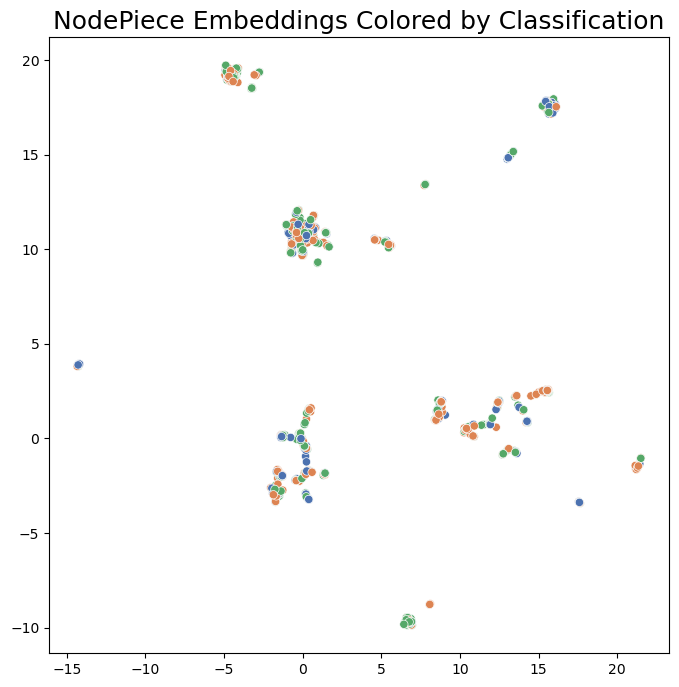

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
sns.set(font_scale=1)

palette = {}
for n, i in enumerate(set([0, 1, 2])):
    palette[i] = f'C{n}'
    
sns.scatterplot(ax=axs, x=embd_x.T[0], y=embd_x.T[1], hue=df["y"], palette=palette)
axs.get_legend().remove()
plt.title("NodePiece Embeddings Colored by Classification", fontsize=18)

plt.show()